# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether a person will default on their loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

Dataset: The dataset comes customers default payments in Taiwan. More information about the dataset and columns are found in the link below.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#


You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

#### You will be working in pairs for this assessment; please have ONE notebook and be prepared to explain how you worked in your pair.
1. Clean up your data set so that you can do EDA. This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Create polynomial and/or interaction features. You must also create at least 2 new features that are not interactions or polynomial transformations. For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.
4. Perform some feature selction. This can happen beforehand using F-scores, or you can do it as part of your model building process by looking at the weights of your regularized logistic regression or feature importance of your decision tree.  
5. You must fit each of the three models to your data and tune at least 1 hyperparameter per model. 
6. After identifying the best hyperparameters for each model, fit those models to the test set and identify the best model overall using the evaluation metric of your choice.
7. Present your best model.

In [1]:
# import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## 1. Data Cleaning

In [2]:
# df = pd.read_csv('student_data.csv')
df = pd.read_csv('clean_with_new_columns.csv')
pd.set_option('display.max_columns', None)

In [11]:
df['default payment next month'].value_counts()

0.0    18678
1.0     5307
Name: default payment next month, dtype: int64

In [143]:
df.head()

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,amount_owed6,amount_owed5,amount_owed4,amount_owed3,amount_owed2,late_pay,sex_2.0,edu_2.0,edu_3.0,edu_4.0,marriage_2.0,marriage_3.0,age_2,age_3,age_4,age_5,age_6
0,350000.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,316.0,316.0,316.0,466.0,466.0,316.0,316.0,316.0,466.0,466.0,316.0,316.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0,0,0,0,1,0,1,0,0,0,0
1,50000.0,2.0,2.0,2.0,0.0,0.0,0.0,40994.0,43594.0,38222.0,13026.0,13268.0,13497.0,5500.0,0.0,580.0,600.0,600.0,600.0,0.0,12897.0,12668.0,12446.0,38222.0,38094.0,6.0,1,1,0,0,0,0,1,0,0,0,0
2,50000.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3430.0,2478.0,2299.0,4800.0,9810.0,660.0,2548.0,2321.0,4800.0,9810.0,660.0,2980.0,0.0,0.0,0.0,0.0,-22.0,-70.0,-6.0,1,0,0,0,1,0,0,0,0,0,0
3,20000.0,0.0,0.0,0.0,0.0,2.0,0.0,10847.0,12176.0,12884.0,13784.0,13420.0,13686.0,1508.0,1216.0,1116.0,0.0,490.0,658.0,0.0,13196.0,13420.0,12668.0,11668.0,10668.0,2.0,0,0,1,0,0,0,0,0,1,0,0
4,110000.0,0.0,0.0,0.0,0.0,0.0,0.0,108159.0,106812.0,108464.0,108829.0,110557.0,106082.0,5400.0,5400.0,4100.0,4100.0,4100.0,4200.0,0.0,101982.0,106457.0,104729.0,103064.0,101412.0,0.0,1,1,0,0,1,0,1,0,0,0,0


In [96]:
# create dummies 
sex_dummies = pd.get_dummies(df_target['SEX'], prefix='sex', drop_first=True)
education_dummies = pd.get_dummies(df_target['EDUCATION'], prefix = 'edu', drop_first = True)
marriage_dummies = pd.get_dummies(df_target['MARRIAGE'], prefix = 'marriage', drop_first = True)

df_target = df_target.drop(['SEX', 'EDUCATION', 'MARRIAGE'], axis=1)
df_target = pd.concat([df_target, sex_dummies], axis=1)
df_target = pd.concat([df_target, education_dummies], axis=1)
df_target = pd.concat([df_target, marriage_dummies], axis=1)

In [93]:
df_target['AgeBin'] = 0 #creates a column of 0
df_target.loc[((df_target['AGE'] > 20) & (df_target['AGE'] < 30)) , 'AgeBin'] = 1
df_target.loc[((df_target['AGE'] >= 30) & (df_target['AGE'] < 40)) , 'AgeBin'] = 2
df_target.loc[((df_target['AGE'] >= 40) & (df_target['AGE'] < 50)) , 'AgeBin'] = 3
df_target.loc[((df_target['AGE'] >= 50) & (df_target['AGE'] < 60)) , 'AgeBin'] = 4
df_target.loc[((df_target['AGE'] >= 60) & (df_target['AGE'] < 70)) , 'AgeBin'] = 5
df_target.loc[((df_target['AGE'] >= 70) & (df_target['AGE'] < 81)) , 'AgeBin'] = 6
# df_target.AgeBin.hist()

In [94]:
df_target.drop(columns = 'AGE', inplace = True, axis =1)

In [95]:
age_dummies = pd.get_dummies(df_target['AgeBin'], prefix = 'age', drop_first = True)

df_target = df_target.drop(['AgeBin'], axis=1)
df_target = pd.concat([df_target, age_dummies], axis=1)

In [13]:
# pay_amt 5 = bill_amt6
df.shape

(23985, 32)

In [90]:
df_target['amount_owed6'] = df_target['BILL_AMT6']- df_target['PAY_AMT5']
df_target['amount_owed5'] = df_target['BILL_AMT5']- df_target['PAY_AMT4']
df_target['amount_owed4'] = df_target['BILL_AMT4']- df_target['PAY_AMT3']
df_target['amount_owed3'] = df_target['BILL_AMT3']- df_target['PAY_AMT2']
df_target['amount_owed2'] = df_target['BILL_AMT2']- df_target['PAY_AMT1']

In [91]:
df_target['late_pay'] = df_target["PAY_0"] + df_target["PAY_2"]+ df_target["PAY_3"]+ df_target["PAY_4"]+ df_target["PAY_5"]+ df_target["PAY_6"]
df_target.loc[(df_target['EDUCATION'] == 0) | (df_target['EDUCATION'] == 5) | (df_target['EDUCATION'] == 6), 'EDUCATION'] = 4
df_target.drop(columns = 'ID', inplace = True)
df_target.MARRIAGE.replace(0.0, 3.0, inplace =True)

In [92]:
df.drop(columns =['Unnamed: 0'], inplace = True)

KeyError: "['Unnamed: 0'] not found in axis"

In [9]:
df.head()

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,amount_owed6,amount_owed5,amount_owed4,amount_owed3,amount_owed2,late_pay,sex_2.0,edu_2.0,edu_3.0,edu_4.0,marriage_2.0,marriage_3.0,age_2,age_3,age_4,age_5,age_6
0,350000.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,316.0,316.0,316.0,466.0,466.0,316.0,316.0,316.0,466.0,466.0,316.0,316.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0,0,0,0,1,0,1,0,0,0,0
1,50000.0,2.0,2.0,2.0,0.0,0.0,0.0,40994.0,43594.0,38222.0,13026.0,13268.0,13497.0,5500.0,0.0,580.0,600.0,600.0,600.0,0.0,12897.0,12668.0,12446.0,38222.0,38094.0,6.0,1,1,0,0,0,0,1,0,0,0,0
2,50000.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3430.0,2478.0,2299.0,4800.0,9810.0,660.0,2548.0,2321.0,4800.0,9810.0,660.0,2980.0,0.0,0.0,0.0,0.0,-22.0,-70.0,-6.0,1,0,0,0,1,0,0,0,0,0,0
3,20000.0,0.0,0.0,0.0,0.0,2.0,0.0,10847.0,12176.0,12884.0,13784.0,13420.0,13686.0,1508.0,1216.0,1116.0,0.0,490.0,658.0,0.0,13196.0,13420.0,12668.0,11668.0,10668.0,2.0,0,0,1,0,0,0,0,0,1,0,0
4,110000.0,0.0,0.0,0.0,0.0,0.0,0.0,108159.0,106812.0,108464.0,108829.0,110557.0,106082.0,5400.0,5400.0,4100.0,4100.0,4100.0,4200.0,0.0,101982.0,106457.0,104729.0,103064.0,101412.0,0.0,1,1,0,0,1,0,1,0,0,0,0


In [18]:
df['EDUCATION'].value_counts()

2.0    11183
1.0     8436
3.0     3991
4.0      375
Name: EDUCATION, dtype: int64

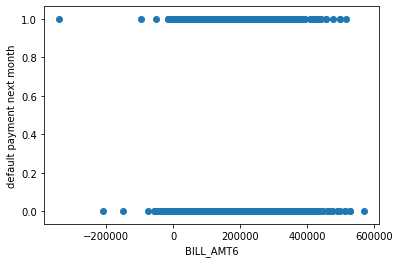

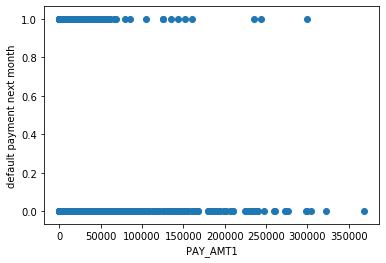

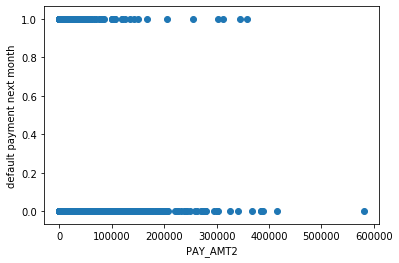

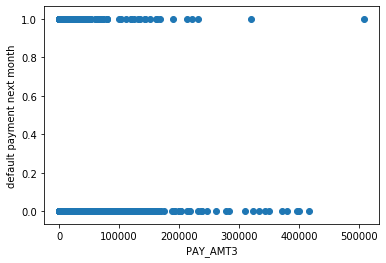

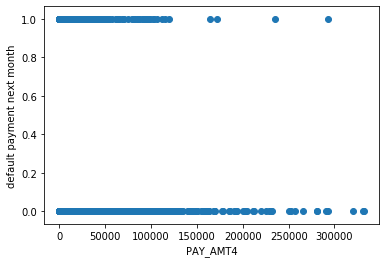

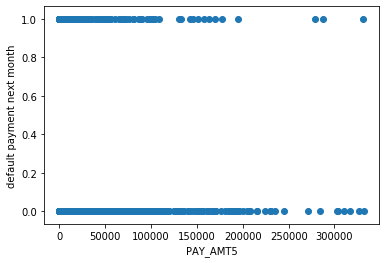

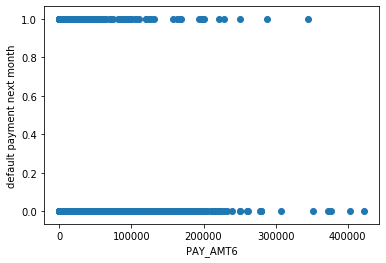

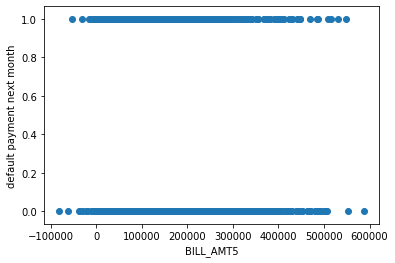

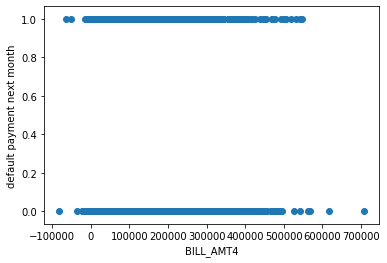

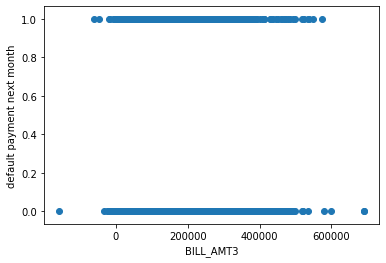

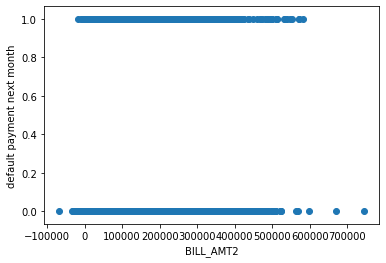

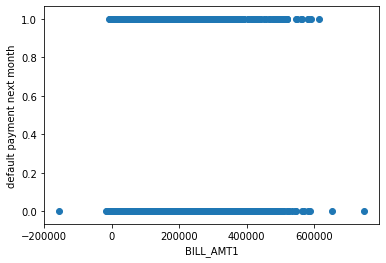

In [19]:
variable = ['BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'BILL_AMT5', 'BILL_AMT4', 'BILL_AMT3', 'BILL_AMT2', 'BILL_AMT1'] 

def bill_pay_amt(df, var):
    df = df.copy()
    
    plt.scatter(df[var], df['default payment next month'])
    plt.ylabel('default payment next month')
    plt.xlabel(var)
    plt.show()
    
for var in variable:
    bill_pay_amt(df, var)

In [97]:
df.loc[df['BILL_AMT1'] > 800000] = np.nan
df.loc[df['BILL_AMT2'] > 800000] = np.nan
df.loc[df['BILL_AMT3'] > 1000000] = np.nan
df.loc[df['BILL_AMT4'] > 800000] = np.nan
df.loc[df['BILL_AMT5'] > 800000] = np.nan
df.loc[df['PAY_AMT6'] > 500000] = np.nan
df.loc[df['PAY_AMT5'] > 350000] = np.nan
df.loc[df['PAY_AMT4'] > 400000] = np.nan
df.loc[df['PAY_AMT3'] > 600000] = np.nan
df.loc[df['PAY_AMT2'] > 750000] = np.nan
df.loc[df['PAY_AMT1'] > 400000] = np.nan
df.loc[df['BILL_AMT6'] > 600000] = np.nan

df.dropna(inplace = True)

In [21]:
df['PAY_6'].value_counts()

 0.0    13087
-1.0     4555
-2.0     3878
 2.0     2211
 3.0      146
 4.0       42
 7.0       39
 6.0       14
 5.0       11
 8.0        2
Name: PAY_6, dtype: int64

In [22]:
df.shape

(23985, 30)

In [23]:
# df.to_csv('clean_with_new_columns.csv')

In [24]:
df['MARRIAGE'].value_counts()

2.0    12728
1.0    10952
3.0      305
Name: MARRIAGE, dtype: int64

## 2. EDA

In [25]:
plt.hist(df['AGE'], bins = )

SyntaxError: invalid syntax (<ipython-input-25-4e39127ce1d3>, line 1)

In [ ]:
df['AGE'].describe()

In [ ]:
plt.hist(df['BILL_AMT3'] )

## 3. Feature Engineering

## 4. Feature Selection

In [ ]:
corr = df.corr()
sns.heatmap(corr)

In [ ]:
# df.drop(columns = ['amount_owed6', 'amount_owed5', 'amount_owed4', 'amount_owed3', 'amount_owed2'], inplace = True)

In [26]:
df.dtypes

LIMIT_BAL                     float64
SEX                           float64
EDUCATION                     float64
MARRIAGE                      float64
AGE                           float64
PAY_0                         float64
PAY_2                         float64
PAY_3                         float64
PAY_4                         float64
PAY_5                         float64
PAY_6                         float64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default payment next month    float64
amount_owed6                  float64
amount_owed5                  float64
amount_owed4

## Logistic Regression

In [127]:
X = df.drop('default payment next month', axis = 1)
y= df['default payment next month']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

Balanced

In [128]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight= 'balanced')

logreg.fit(X_train, y_train)

/Users/michaelarmistead/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [129]:
pred = logreg.predict(X_test)
f1_score(y_test, pred)

0.4110188019239178

## Bagging

In [131]:
from sklearn.ensemble import BaggingClassifier 

In [132]:
X = df.drop('default payment next month', axis = 1)
y= df['default payment next month']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [133]:
bag = BaggingClassifier(random_state = 1, max_features = 25, n_estimators = 15, max_samples = 100)
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=25, max_samples=100, n_estimators=15,
                  n_jobs=None, oob_score=False, random_state=1, verbose=0,
                  warm_start=False)

In [134]:
pred = bag.predict(X_test)
f1_score(y_test, pred)

0.3907928388746803

Penalty is ridge or lasso and c is alpha

##  gridsearch bagging

In [15]:
from sklearn.model_selection import GridSearchCV

In [169]:
params = {'max_samples' : (60, 70, 80, 90, 100)}

In [170]:
gsearchbag = GridSearchCV(
    estimator = bag,
    param_grid = params,
    scoring = 'f1',
    n_jobs = -1,
    verbose = 1,
    iid = False,
    cv = 5)

In [171]:
gsearchbag.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.1s finished
/Users/michaelarmistead/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
                                         bootstrap_features=False,
                                         max_features=25, max_samples=1.0,
                                         n_estimators=15, n_jobs=None,
                                         oob_score=False, random_state=1,
                                         verbose=0, warm_start=False),
             iid=False, n_jobs=-1,
             param_grid={'max_samples': (60, 70, 80, 90, 100)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=1)

In [172]:
gsearchbag.best_params_

{'max_samples': 100}

In [173]:
gsearchbag.best_score_

0.4390065130845068

In [174]:
preds = gsearchbag.best_estimator_.predict(X_test)
test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)
print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.801234
F1: 0.383661


## XGBoost

In [1]:
import xgboost as xgb

In [135]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', learning_rate = .3, max_depth = 4, n_estimators = 30, colsample_bytree = .3, min_child_weight = 4, max_delta_step = 1)
clf_xgb.fit(X_train, y_train)
pred = clf_xgb.predict(X_test)

In [136]:
f1_score(y_test, pred)

0.4460856720827179

XGBoost Grid

In [44]:
xgb.XGBClassifier()

clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', learning_rate = .3, max_depth = 4, n_estimators = 30, colsample_bytree = .3, min_child_weight = 4, max_delta_step = 1)
param_dist = {'max_delta_step': (.9, 1, 1.1)}

In [45]:
gsearch1 = GridSearchCV(
    estimator = clf_xgb,
    param_grid = param_dist,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    iid=False,
    cv=5)

gsearch1.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.0s finished
/Users/michaelarmistead/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.3, gamma=0,
                                     learning_rate=0.3, max_delta_step=0,
                                     max_depth=4, min_child_weight=4,
                                     missing=None, n_estimators=30, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid=False, n_jobs=-1, param_grid={'max_delta_step': (0.9, 1, 1.1)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=1)

In [46]:
gsearch1.best_params_

{'max_delta_step': 1}

In [43]:
gsearch1.best_score_

0.4832721021771575

In [202]:
preds = gsearch1.best_estimator_.predict(X_test)
test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)
print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.817909
F1: 0.461007


##  KNN

In [122]:
X = df.drop('default payment next month', axis = 1)
y= df['default payment next month']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [123]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [124]:
knn = KNeighborsClassifier(n_neighbors= 5)
knn.fit(X_train, y_train)
y_pred =knn.predict(X_test)

In [125]:
test_f1 = f1_score(y_test, y_pred)
test_f1

0.406971267074894

In [126]:
accuracy_score(y_test, y_pred)

0.7900616975154244

0.40302029259084476

## Checking Min Max Scaler (KNN)
Going to use standard

In [59]:
X = df.drop('default payment next month', axis = 1)
y= df['default payment next month']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [113]:
minmax = MinMaxScaler()
minmax.fit(X_train)

X_train = minmax.transform(X_train)
X_test = minmax.transform(X_test)

In [118]:
knn = KNeighborsClassifier(n_neighbors= 3)
knn.fit(X_train, y_train)
y_pred =knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.7732199433049858

In [119]:
test_f1 = f1_score(y_test, y_pred)
test_f1

0.40611353711790393

In [146]:
df.shape

(23985, 37)

## Optimal K values
k = 3 is the best

In [116]:
k_scores =[]

k_range = list(range(1,12))
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors= k)
    knn.fit(X_train, y_train)
    
    y_pred =knn.predict(X_test)
    
    test_f1 = f1_score(y_test, y_pred)
    
    k_scores.append(test_f1)
    print(k_scores)

[0.3698891860909438]
[0.3698891860909438, 0.27827050997782704]
[0.3698891860909438, 0.27827050997782704, 0.40611353711790393]
[0.3698891860909438, 0.27827050997782704, 0.40611353711790393, 0.33315363881401616]
[0.3698891860909438, 0.27827050997782704, 0.40611353711790393, 0.33315363881401616, 0.40302743614001896]
[0.3698891860909438, 0.27827050997782704, 0.40611353711790393, 0.33315363881401616, 0.40302743614001896, 0.3502945902517407]
[0.3698891860909438, 0.27827050997782704, 0.40611353711790393, 0.33315363881401616, 0.40302743614001896, 0.3502945902517407, 0.3984413054067219]
[0.3698891860909438, 0.27827050997782704, 0.40611353711790393, 0.33315363881401616, 0.40302743614001896, 0.3502945902517407, 0.3984413054067219, 0.35614973262032085]
[0.3698891860909438, 0.27827050997782704, 0.40611353711790393, 0.33315363881401616, 0.40302743614001896, 0.3502945902517407, 0.3984413054067219, 0.35614973262032085, 0.3959595959595959]
[0.3698891860909438, 0.27827050997782704, 0.40611353711790393, 

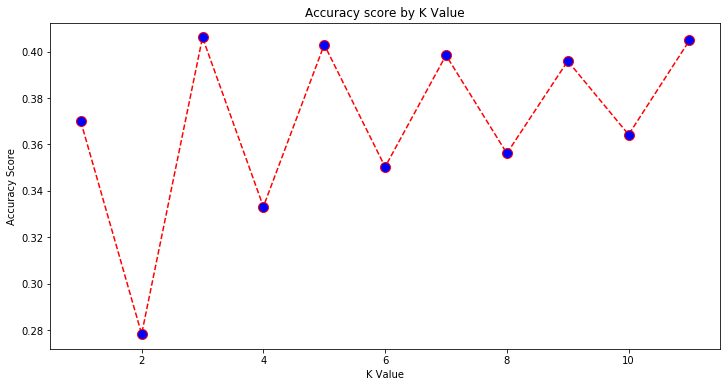

In [117]:
plt.figure(figsize=(12, 6))  
plt.plot(k_range, k_scores, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Accuracy score by K Value')  
plt.xlabel('K Value')  
plt.ylabel('Accuracy Score') 
plt.show()

## Random Forest 

In [12]:
from sklearn.ensemble import RandomForestClassifier 

In [60]:
clf_cv = RandomForestClassifier(random_state=27, class_weight = 'balanced', n_estimators = 250, min_samples_leaf = 3, max_depth = 12, max_leaf_nodes = 225, max_features = 15, min_samples_split= 15)
clf_cv.fit(X_train, y_train)
# preds = clf_cv.predict(X_test)
# f1_score(y_test, preds)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=12, max_features=15,
                       max_leaf_nodes=225, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

In [10]:
X = df.drop('default payment next month', axis = 1)
y= df['default payment next month']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [51]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
f1_score(y_test, preds)

0.436222005842259

In [48]:
clf_cv = RandomForestClassifier(random_state=27, class_weight = 'balanced', n_estimators = 250, min_samples_leaf = 3, max_depth = 12, max_leaf_nodes = 225, max_features = 15, min_samples_split= 15)
param_dist = {
    'min_samples_split': (8, 11, 15, 20)
    }



In [49]:
gsearchrf = GridSearchCV(
    estimator = clf_cv,
    param_grid = param_dist,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    iid=False,
    cv=5)

gsearchrf.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.6min finished
/Users/michaelarmistead/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=12,
                                              max_features=15,
                                              max_leaf_nodes=225,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=3,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=250, n_jobs=None,
                                              oob_score=False, random_state=27,
                                   

In [50]:
gsearchrf.best_params_

{'min_samples_split': 15}

In [51]:
gsearchrf.best_score_

0.546807530263289

In [52]:
preds = gsearchrf.best_estimator_.predict(X_test)
test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)
print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.781057
F1: 0.524792


## 6. Model Evaluation

## 7. Final Model

In [89]:
df_target = pd.read_csv('hold_out_features.csv')
pd.set_option('display.max_columns', None)
df_target.head()

,Unnamed: 0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0,6320,240000,1,1,1,44,-1,-1,-1,-1,-1,-1,4221,2188,2701,2427,1104,2362,2188,2701,2427,1104,2362,519
1,1,29659,50000,1,3,1,41,0,0,0,0,0,0,49782,50741,48468,39203,28913,26636,1816,1753,1433,990,967,1071
2,2,28347,20000,2,3,1,41,0,0,0,0,0,0,8777,10461,11583,13079,14546,16149,2000,1600,2000,2000,2000,2000
3,3,8523,320000,2,1,2,34,-2,-2,-2,-2,-2,-2,-532,-532,-528,-1336,-1336,-1336,0,4,0,0,0,0
4,4,22135,120000,2,2,1,23,0,0,0,0,0,0,64049,65984,66825,68820,69776,71297,3000,2500,3100,2700,2800,2800


In [100]:
df_target.drop(columns = ['Unnamed: 0'], inplace = True)
df_target.head()

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,amount_owed6,amount_owed5,amount_owed4,amount_owed3,amount_owed2,late_pay,age_2,age_3,age_4,age_5,age_6,sex_2,edu_2,edu_3,edu_4,marriage_2.0,marriage_3.0
0,240000,-1,-1,-1,-1,-1,-1,4221,2188,2701,2427,1104,2362,2188,2701,2427,1104,2362,519,0,0,0,0,0,-6,0,1,0,0,0,0,0,0,0,0,0
1,50000,0,0,0,0,0,0,49782,50741,48468,39203,28913,26636,1816,1753,1433,990,967,1071,25669,27923,37770,46715,48925,0,0,1,0,0,0,0,0,1,0,0,0
2,20000,0,0,0,0,0,0,8777,10461,11583,13079,14546,16149,2000,1600,2000,2000,2000,2000,14149,12546,11079,9983,8461,0,0,1,0,0,0,1,0,1,0,0,0
3,320000,-2,-2,-2,-2,-2,-2,-532,-532,-528,-1336,-1336,-1336,0,4,0,0,0,0,-1336,-1336,-1336,-532,-532,-12,1,0,0,0,0,1,0,0,0,1,0
4,120000,0,0,0,0,0,0,64049,65984,66825,68820,69776,71297,3000,2500,3100,2700,2800,2800,68497,67076,65720,64325,62984,0,0,0,0,0,0,1,1,0,0,0,0


In [56]:
from cleaning import clean_data
clean_data(df_target)

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,amount_owed6,amount_owed5,amount_owed4,amount_owed3,amount_owed2,sex_2,edu_2,edu_3,edu_4,marriage_2.0,marriage_3.0,age_2,age_3,age_4,age_5,age_6
0,240000,44,-1,-1,-1,-1,-1,-1,4221,2188,2701,2427,1104,2362,2188,2701,2427,1104,2362,519,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,50000,41,0,0,0,0,0,0,49782,50741,48468,39203,28913,26636,1816,1753,1433,990,967,1071,25669,27923,37770,46715,48925,0,0,1,0,0,0,0,1,0,0,0
2,20000,41,0,0,0,0,0,0,8777,10461,11583,13079,14546,16149,2000,1600,2000,2000,2000,2000,14149,12546,11079,9983,8461,1,0,1,0,0,0,0,1,0,0,0
3,320000,34,-2,-2,-2,-2,-2,-2,-532,-532,-528,-1336,-1336,-1336,0,4,0,0,0,0,-1336,-1336,-1336,-532,-532,1,0,0,0,1,0,1,0,0,0,0
4,120000,23,0,0,0,0,0,0,64049,65984,66825,68820,69776,71297,3000,2500,3100,2700,2800,2800,68497,67076,65720,64325,62984,1,1,0,0,0,0,0,0,0,0,0


In [81]:
sex_dummies = pd.get_dummies(df_target['SEX'], prefix='sex', drop_first=True)
education_dummies = pd.get_dummies(df_target['EDUCATION'], prefix = 'edu', drop_first = True)
marriage_dummies = pd.get_dummies(df_target['MARRIAGE'], prefix = 'marriage', drop_first = True)

df_target = df_target.drop(['SEX', 'EDUCATION', 'MARRIAGE'], axis=1)
df_target = pd.concat([df_target, sex_dummies], axis=1)
df_target = pd.concat([df_target, education_dummies], axis=1)
df_target = pd.concat([df_target, marriage_dummies], axis=1)

In [101]:
preds = clf_cv.predict(df_target)

In [103]:
pred_df = pd.DataFrame(preds)


In [104]:
pred_df

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
5996,1.0
5997,1.0
5998,1.0
5999,0.0


In [105]:
pred_df.to_csv('default_preds_ohma.csv', index = False, header = False)